<h2> Dựa trên dữ liệu OSMI đã được làm sạch và chạy trên một số mô hình Logistic, K-neighbors Classifier, Decision Tree Classifier, C-Support Vector Classification, Bangging, AdaBoost</h2>

In [60]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


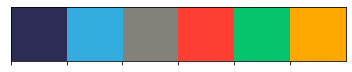

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt
# %matplotlib inline
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')
          
flatUI = ["#2c2c54", "#34ace0", "#84817a", "#ff3f34", "#05c46b", "#ffa801"]
sns.set_palette(flatUI)
sns.palplot(sns.color_palette())
plt.show()

def showFigure(fig, x=16, y=4):
    fig = plt.gcf()
    fig.set_size_inches(x, y)
    plt.show()

In [62]:
import numpy as np
import pandas as pd  # data processing, CSV file I/O

survey = pd.read_csv('/content/drive/MyDrive/MentalHealth/cleanedDatasets/OSMIcleaned.csv')

y = survey['Sought Treatment']

def bestFill(datset):
    for feature in survey:
        if survey[feature].dtype == np.int64:
             print('int64, not available = -1 : ', feature)
             survey[feature] = pd.to_numeric(survey[feature], errors='coerce').astype(int)
             survey[feature].fillna(-1, inplace=True)
 
        elif survey[feature].dtype == np.float64:
             print('float64, not available = -1 : ', feature)
             survey[feature].fillna(-1, inplace=True)
             survey[feature] = pd.to_numeric(survey[feature], errors='coerce').astype(float)

        elif survey[feature].dtype == np.object:
             print('object, not available = NaN : ', feature)
             survey[feature].fillna('NaN', inplace=True)
            
bestFill(survey)        

features= ['Family History of Mental Illness',
        'Company Size', 
        'year',
        'Age', 
        'Age-Group', 
        'Gender', 
        'Prefer Anonymity',
        'Rate Reaction to Problems', 
        'Negative Consequences',
        'Access to information', 
        'Diagnosis',
        'Insurance',
        'Discuss Mental Health Problems', 
        'Responsible Employer', 
        'Disorder',
        'Primarily a Tech Employer']   

X = survey[features]

object, not available = NaN :  Family History of Mental Illness
object, not available = NaN :  Company Size
int64, not available = -1 :  year
int64, not available = -1 :  Age
object, not available = NaN :  Age-Group
object, not available = NaN :  Gender
int64, not available = -1 :  Sought Treatment
object, not available = NaN :  Describe Past Experience
float64, not available = -1 :  Prefer Anonymity
object, not available = NaN :  Rate Reaction to Problems
object, not available = NaN :  Negative Consequences
object, not available = NaN :  Location
int64, not available = -1 :  Access to information
float64, not available = -1 :  Insurance
object, not available = NaN :  Diagnosis
object, not available = NaN :  Discuss Mental Health Problems
object, not available = NaN :  Responsible Employer
object, not available = NaN :  Disorder Notes
int64, not available = -1 :  Disorder
float64, not available = -1 :  Primarily a Tech Employer


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Dữ liệu được chia thành hai phần phần là test và train, test 60% và train 40%

In [63]:
numerical_features = (X.dtypes == 'float') | (X.dtypes == 'int')
categorical_features = ~numerical_features

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
preprocess = make_column_transformer(
    (StandardScaler(), numerical_features),
    (OneHotEncoder(), categorical_features), remainder="drop", n_jobs= -1, verbose = True
)

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.30, random_state=1)

# Accuracy of each model
models = {}

Để đánh giá kết quả của mỗi mô hình, một hàm được xác định để chỉ ra và vẽ biểu đồ một số đặc điểm của mô hình trong quan điểm.

In [64]:
from sklearn.pipeline import make_pipeline
from sklearn import metrics
def evaluateModel(model, yPredClass, plot=False):
    # Classification Accuracy: Overall, how often is the classifier correct?
    accuracy = metrics.accuracy_score(Y_test, yPredClass)
    print('Classification Accuracy:', accuracy*100)
    
    # Comparing the true and predicted response values
    print('\nTrue:', Y_test.values[0:25])
    print('Pred:', yPredClass[0:25])
   
    # Metrics computed from a confusion matrix
    confusion = metrics.confusion_matrix(Y_test, yPredClass)
    # [row, column]
    TP = confusion[1, 1]   # True Positive
    TN = confusion[0, 0]   # True Negative
    FP = confusion[0, 1]   # False Positive
    FN = confusion[1, 0]   # False Negative
    
    # False Positive Rate: When the actual value is negative, how often is the prediction incorrect?
    false_positive_rate = FP / float(FP+TN)
    print('\nFalse Positive Rate:', false_positive_rate)

    # Precision: When a positive value is predicted, how often is the prediction correct?
    print('Precision:', metrics.precision_score(Y_test, yPredClass))

    # IMPORTANT: first argument is true values, second argument is predicted probabilities
    print('AUC Score:', metrics.roc_auc_score(Y_test, yPredClass))
    # store the predicted probabilities for class 1
    y_pred_prob = model.predict_proba(X_test)[:, 1]

    # visualize Confusion Matrix
    fig = sns.heatmap(confusion, annot=True, fmt="d")
    bottom, top = fig.get_ylim()
    fig.set_ylim(bottom + 0.5, top - 0.5)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # histogram of predicted probabilities
    if plot:
        plt.rcParams['font.size'] = 12
        plt.hist(y_pred_prob, bins=4)
        # x-axis limit from 0 to 1
        plt.xlim(0, 1)
        plt.title('Histogram of predicted probabilities')
        plt.xlabel('Predicted probability of treatment')
        plt.ylabel('Frequency')

    # AUC is the percentage of the ROC plot that is underneath the curve
    # Higher value = better classifier
    roc_auc = metrics.roc_auc_score(Y_test, y_pred_prob)

    # roc_curve returns 3 objects fpr, tpr, thresholds
    # fpr: false positive rate
    # tpr: true positive rate
    fpr, tpr, thresholds = metrics.roc_curve(Y_test, y_pred_prob)
    if plot:
        plt.figure()
        plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.rcParams['font.size'] = 12
        plt.title('ROC curve for treatment classifier')
        plt.xlabel('False Positive Rate (1 - Specificity)')
        plt.ylabel('True Positive Rate (Sensitivity)')
        plt.legend(loc="lower right")
        plt.show()

    return accuracy

<h1>Logistic Regression</h1>

############### Logistic Regression ###############
Classification Accuracy: 81.01545253863135

True: [1 1 0 1 0 1 0 0 0 0 1 0 1 0 0 1 1 0 1 1 1 0 1 1 1]
Pred: [1 1 0 1 0 1 0 0 0 0 1 0 1 0 0 0 1 0 1 1 1 1 1 1 0]

False Positive Rate: 0.19594594594594594
Precision: 0.8434547908232118
AUC Score: 0.809458578526375


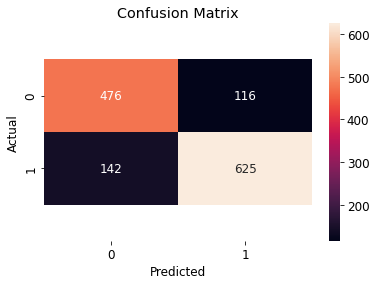

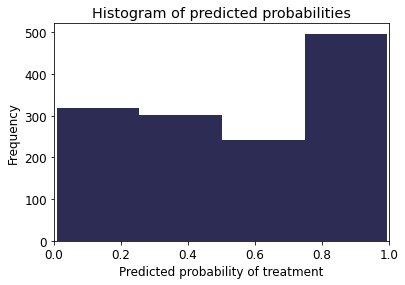

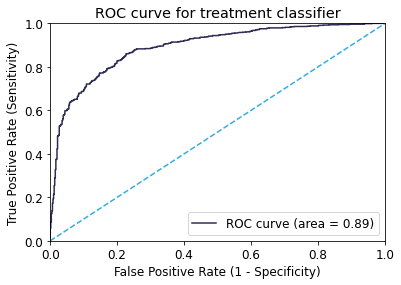

In [65]:
from sklearn.linear_model import LogisticRegression
def logisticRegression():
    modelLogisticRegression = make_pipeline(preprocess, LogisticRegression(solver='liblinear', multi_class='ovr'))
    modelLogisticRegression.fit(X_train, Y_train)

    # make class predictions for the testing set
    y_pred_class = modelLogisticRegression.predict(X_test)

    print('############### Logistic Regression ###############')

    accuracy_score = evaluateModel(modelLogisticRegression, y_pred_class, True)

    models['Logistic Regression'] = accuracy_score * 100
    
logisticRegression()

<h1>K-Neighbors Classifier</h1>

########### K-Neighbors Classifier ###############
Classification Accuracy: 78.21927888153054

True: [1 1 0 1 0 1 0 0 0 0 1 0 1 0 0 1 1 0 1 1 1 0 1 1 1]
Pred: [1 1 0 1 0 1 0 0 0 0 0 0 1 0 0 0 1 0 1 1 1 1 1 1 0]

False Positive Rate: 0.23310810810810811
Precision: 0.8152610441767069
AUC Score: 0.7804472497269108


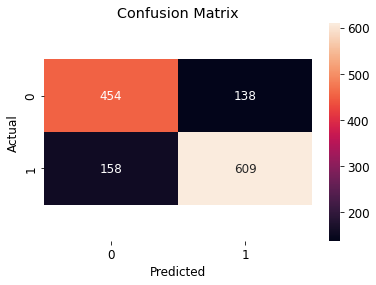

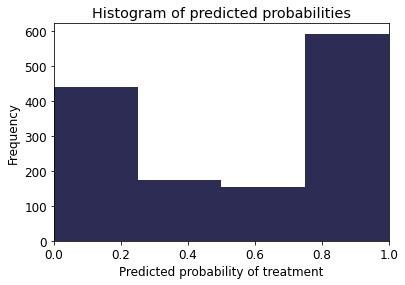

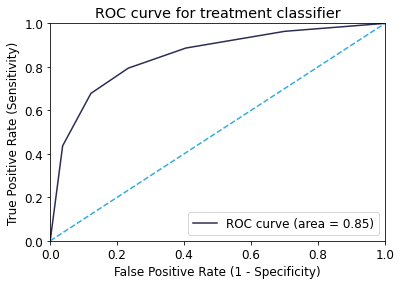

In [66]:
from sklearn.neighbors import KNeighborsClassifier
def kNNClassifier():
    modelKNN = make_pipeline(preprocess, KNeighborsClassifier())
    modelKNN.fit(X_train, Y_train)

    # make class predictions for the testing set
    y_pred_class = modelKNN.predict(X_test)

    print('########### K-Neighbors Classifier ###############')

    accuracy_score = evaluateModel(modelKNN, y_pred_class, True)

    # Data for final graph
    models['K-Neighbors Classifier'] = accuracy_score * 100

kNNClassifier()

<h1> Decision Tree Classifier</h1>

########### Decision Tree Classifier ###############
Classification Accuracy: 72.03826342899191

True: [1 1 0 1 0 1 0 0 0 0 1 0 1 0 0 1 1 0 1 1 1 0 1 1 1]
Pred: [1 1 0 1 1 1 0 0 0 0 1 0 1 0 0 1 1 1 1 0 1 0 1 1 0]

False Positive Rate: 0.31756756756756754
Precision: 0.7536041939711664
AUC Score: 0.7160532435956165


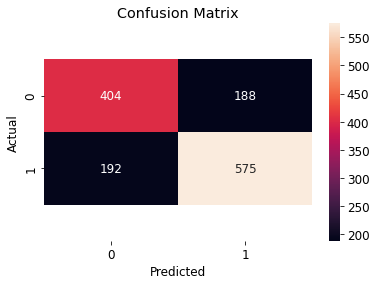

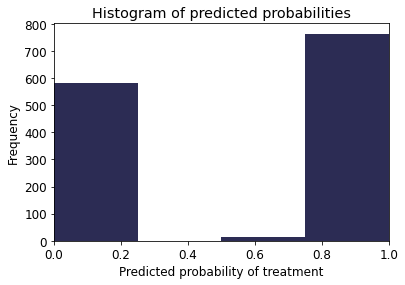

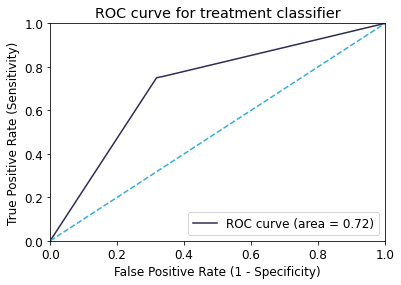

In [67]:
from sklearn.tree import DecisionTreeClassifier
def decisionTreeClassifier():
    # train a logistic regression model on the training set
    modelDecisionTreeClassifier = make_pipeline(preprocess, DecisionTreeClassifier())
    modelDecisionTreeClassifier.fit(X_train, Y_train)

    # make class predictions for the testing set
    y_pred_class = modelDecisionTreeClassifier.predict(X_test)

    print('########### Decision Tree Classifier ###############')

    accuracy_score = evaluateModel(modelDecisionTreeClassifier, y_pred_class, True)

    models['Decision Tree Classifier'] = accuracy_score * 100
    
decisionTreeClassifier()

<h1>C-Support Vector Classification</h1>

########### C-Support Vector Classification ###############
Classification Accuracy: 79.83811626195732

True: [1 1 0 1 0 1 0 0 0 0 1 0 1 0 0 1 1 0 1 1 1 0 1 1 1]
Pred: [1 1 0 1 0 1 0 0 0 0 1 0 0 1 0 0 1 0 1 1 1 1 1 1 0]

False Positive Rate: 0.21452702702702703
Precision: 0.8299866131191432
AUC Score: 0.7969085855738398


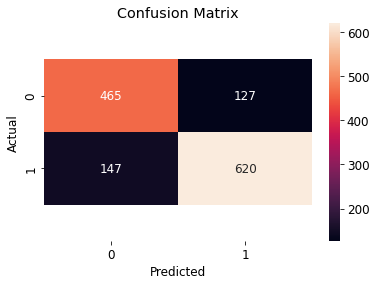

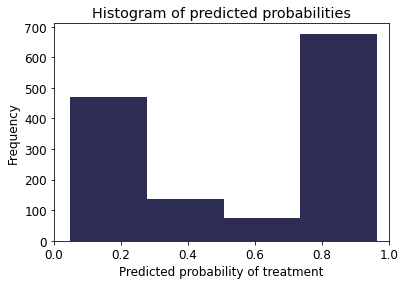

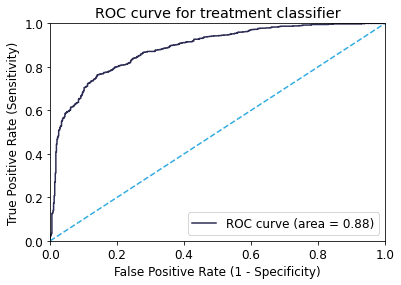

In [68]:
from sklearn.svm import SVC
def SVMClassifier():
    # train a logistic regression model on the training set
    modelSVM = make_pipeline(preprocess, SVC(gamma='auto', probability=True))
    modelSVM.fit(X_train, Y_train)

    # make class predictions for the testing set
    y_pred_class = modelSVM.predict(X_test)

    print('########### C-Support Vector Classification ###############')

    accuracy_score = evaluateModel(modelSVM, y_pred_class, True)

    models['C-Support Vector Classification'] = accuracy_score * 100
    
SVMClassifier()

<h1>Bagging meta-estimator</h1>

########### Bagging meta-estimator ###############
Classification Accuracy: 80.79470198675497

True: [1 1 0 1 0 1 0 0 0 0 1 0 1 0 0 1 1 0 1 1 1 0 1 1 1]
Pred: [1 1 0 1 0 1 0 0 0 0 1 0 0 1 0 0 1 0 1 1 1 1 1 1 0]

False Positive Rate: 0.20777027027027026
Precision: 0.836436170212766
AUC Score: 0.8061539782938087


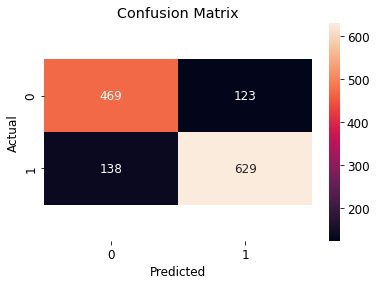

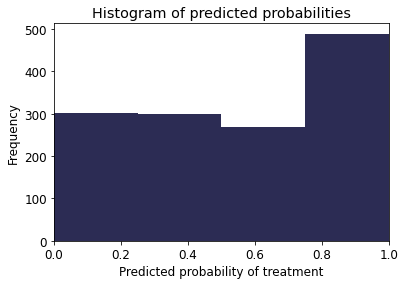

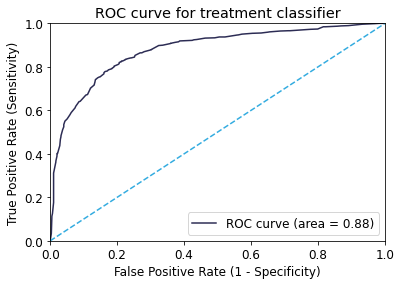

In [69]:
from sklearn.ensemble import BaggingClassifier
def bagging():
    modelBagging = make_pipeline(preprocess, BaggingClassifier(KNeighborsClassifier(), max_samples=0.5, max_features=0.5))
    modelBagging.fit(X_train, Y_train)
    
    # make class predictions for the testing set
    y_pred_class = modelBagging.predict(X_test)

    print('########### Bagging meta-estimator ###############')

    accuracy_score = evaluateModel(modelBagging, y_pred_class, True)

    models['Bagging'] = accuracy_score * 100
    
bagging()    

<h1>AdaBoost</h1>

########### AdaBoost ###############
Classification Accuracy: 81.23620309050773

True: [1 1 0 1 0 1 0 0 0 0 1 0 1 0 0 1 1 0 1 1 1 0 1 1 1]
Pred: [1 1 0 1 0 1 1 0 0 0 1 0 0 1 0 0 1 0 1 1 1 1 1 1 0]

False Positive Rate: 0.18243243243243243
Precision: 0.8516483516483516
AUC Score: 0.812955882871137


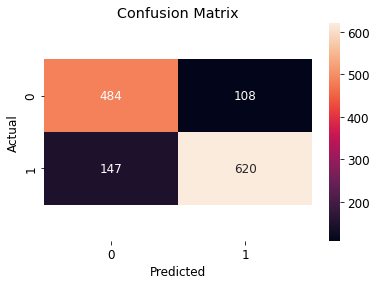

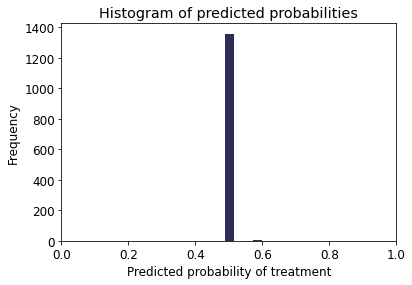

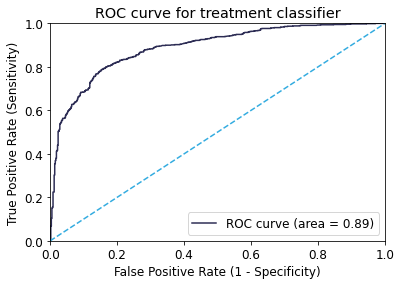

In [70]:
from sklearn.ensemble import AdaBoostClassifier
def adaboost():
    modelAdaBoost = make_pipeline(preprocess, AdaBoostClassifier(n_estimators=100))
    modelAdaBoost.fit(X_train, Y_train)
    
    # make class predictions for the testing set
    y_pred_class = modelAdaBoost.predict(X_test)

    print('########### AdaBoost ###############')

    accuracy_score = evaluateModel(modelAdaBoost, y_pred_class, True)

    models['AdaBoost'] = accuracy_score * 100
    
adaboost()

<h1>Độ chính xác của từng mô hình</h1>

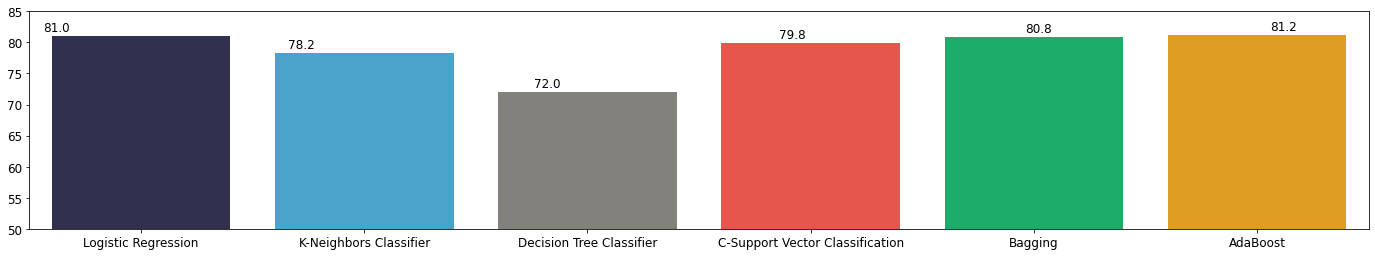

In [71]:
accuracyScores = pd.Series(models)
fig = sns.barplot(x=accuracyScores.index, y=accuracyScores.values)
plt.ylim([50.0, 85.0])
for p in fig.patches:
        fig.annotate(str(round(p.get_height(), 1)), (p.get_x() * 1.1, p.get_height() * 1.01))
showFigure(fig, x=24)

Mô hình có độ chính xác tốt nhất là Ada Boot 81.2%